In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from metrics.overallscore import calculate_overall_score
from metrics.dataquality import calculate_data_quality_metrics
from metrics.dataquality import calculate_phone_number_metrics
from metrics.dataquality import calculate_email_metrics

In [27]:
# data = pd.read_csv("data/ecg/customers_sep_nov.csv")
data = pd.read_csv("data/ecg/customers_two.csv")

In [28]:
column_mapping = {
    'slrn': 'SLRN',
    'ac_no': 'Account Number',
    'meter_number': 'Meter Number',
    'meter_status': 'Meter Status',
    'meter_slrn': 'Meter SLRN',
    'phone_number': 'Phone Number',
    'email': 'Email',
    'date': 'Date',
    'first_captured_username': 'First Captured Username',
    'updated_username': 'Updated Username'
}
data_x = data.copy()
data_x.rename(columns=column_mapping, inplace=True)

In [29]:
df = data_x

In [33]:
def calculate_average_metrics(metrics_list, metric_name):
    # Calculate the average of a specific metric across all key fields
    total_metric = sum(metrics[metric_name] for metrics in metrics_list)
    average_metric = total_metric / len(metrics_list)
    return average_metric

# List to store metrics for each key field
metrics_list = []

# Calculate metrics for each key field
key_fields = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN', 'Phone Number', 'Email']

for field_name in key_fields:
    if field_name in df.columns:
        if field_name in ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']:
            metrics = calculate_data_quality_metrics(df, field_name)
        elif field_name == 'Phone Number':
            metrics = calculate_phone_number_metrics(df, field_name, corresponding_meter_field='Meter Number')
        elif field_name == 'Email':
            metrics = calculate_email_metrics(df, field_name, corresponding_meter_field='Meter Number')
        
        metrics_list.append(metrics)

# Calculate average completeness, validity, and integrity
average_completeness = calculate_average_metrics(metrics_list, 'Completeness')
average_validity = calculate_average_metrics(metrics_list, 'Validity')
average_integrity = calculate_average_metrics(metrics_list, 'Integrity')

# Calculate overall score using the overall_score function
overall_score = calculate_overall_score(average_completeness, average_validity, average_integrity)

# Display the results
print("\nQuality Metrics for Each Field:")
for field_name in key_fields:
    if field_name in df.columns:
        print(f"\nMetrics for {field_name}:")
        print(f"Completeness: {metrics_list[key_fields.index(field_name)]['Completeness']:.2f}%")
        print(f"Validity: {metrics_list[key_fields.index(field_name)]['Validity']:.2f}%")
        print(f"Integrity: {metrics_list[key_fields.index(field_name)]['Integrity']:.2f}%")
        
        # Calculate and print the overall score for each field
        field_overall_score = calculate_overall_score(
            metrics_list[key_fields.index(field_name)]['Completeness'],
            metrics_list[key_fields.index(field_name)]['Validity'],
            metrics_list[key_fields.index(field_name)]['Integrity']
        )
        print(f"Overall Score: {field_overall_score:.2f}")

print("\nQuality Metrics - Average and Overall Score:")
print(f"Average Completeness: {average_completeness:.2f}%")
print(f"Average Validity: {average_validity:.2f}%")
print(f"Average Integrity: {average_integrity:.2f}%")
print(f"Overall Score: {overall_score:.2f}")



Quality Metrics for Each Field:

Metrics for SLRN:
Completeness: 100.00%
Validity: 99.91%
Integrity: 100.00%
Overall Score: 100.00

Metrics for Account Number:
Completeness: 87.67%
Validity: 81.42%
Integrity: 100.00%
Overall Score: 88.00

Metrics for Meter Number:
Completeness: 99.98%
Validity: 99.15%
Integrity: 56.95%
Overall Score: 91.20

Metrics for Meter SLRN:
Completeness: 99.97%
Validity: 99.81%
Integrity: 99.98%
Overall Score: 100.00

Metrics for Phone Number:
Completeness: 76.37%
Validity: 59.76%
Integrity: 51.03%
Overall Score: 64.80

Metrics for Email:
Completeness: 50.51%
Validity: 17.20%
Integrity: 0.54%
Overall Score: 27.20

Quality Metrics - Average and Overall Score:
Average Completeness: 85.75%
Average Validity: 76.21%
Average Integrity: 68.08%
Overall Score: 78.40



Sample Data: 904,687

Metrics for Phone Number:
Completeness: 76.37%
Validity: 59.76%
Integrity: 51.03%
Overall Score: 62.39%

Metrics for Email:
Completeness: 50.51%
Validity: 17.20%
Integrity: 0.54%
Overall Score: 30.15%

Metrics for SLRN:
Completeness: 100.00%
Validity: 99.91%
Integrity: 100.00%
Overall Score: 99.97%

Metrics for Account Number:
Completeness: 87.67%
Validity: 81.42%
Integrity: 100.00%
Overall Score: 89.70%

Metrics for Meter Number:
Completeness: 99.98%
Validity: 99.15%
Integrity: 56.95%
Overall Score: 85.36%

Metrics for Meter SLRN:
Completeness: 99.97%
Validity: 99.81%
Integrity: 99.98%
Overall Score: 99.92%

Meter Status Integrity Issues:
                 SLRN Account Number  Meter Number Meter Status  \
8           BD0009073      727912282    p161089005    Unmetered   
13          BD0009073      211187156    0211187156    Unmetered   
20      ECGBBD0032602      171025158     171025158    Unmetered   
141      ECGBD0000057     7003677680    p181175771    Unmeter

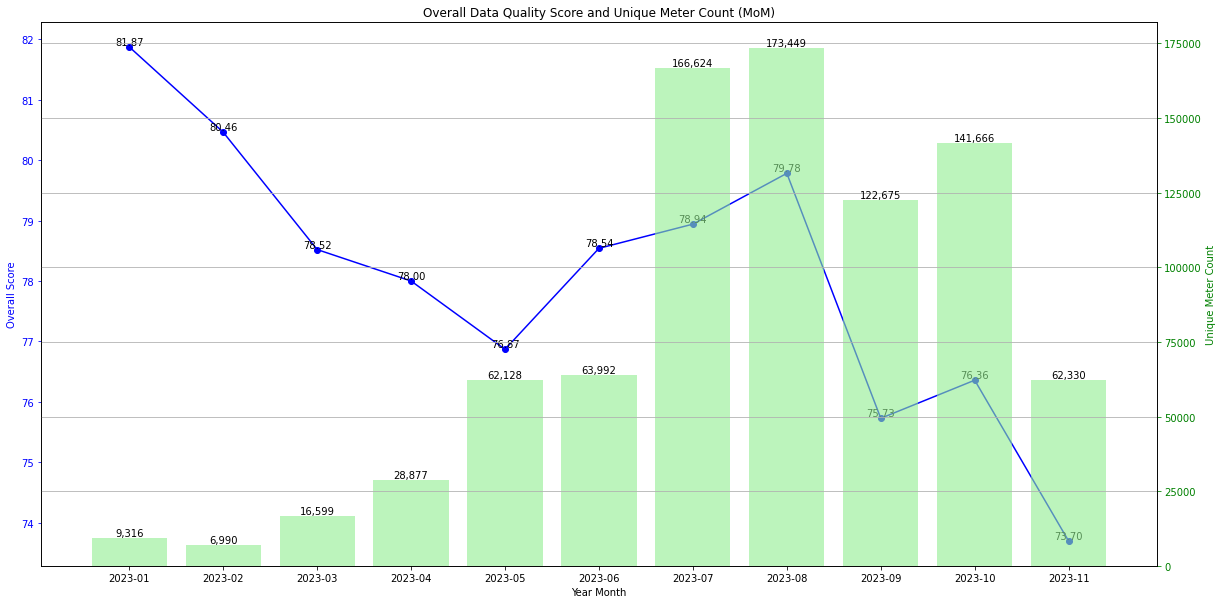

In [5]:
df = data_x

def calculate_data_quality_metrics(df, field_name):
    metrics = {}
    
    # Only calculate metrics for specified fields
    if field_name in ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']:
        # Completeness
        metrics['Completeness'] = df[field_name].count() / len(df) * 100

        # Validity
        if field_name == 'SLRN':
            # Validity check for SLRN (e.g., prefix 'ECGBD' and length 12)
            valid_slrn = df[field_name].apply(lambda x: str(x).startswith('ECGBD') and len(str(x)) == 12)
            metrics['Validity'] = valid_slrn.mean() * 100
        elif field_name == 'Meter SLRN':
            # Validity check for Meter SLRN (e.g., prefix 'ECGCR' and length >= 11)
            valid_meter_slrn = df[field_name].apply(lambda x: str(x).startswith('ECGCR') and len(str(x)) >= 11)
            metrics['Validity'] = valid_meter_slrn.mean() * 100
        elif field_name == 'Account Number':
            # Validity check for Account Number (numeric only)
            valid_account_number = df[field_name].apply(lambda x: str(x).isnumeric())
            metrics['Validity'] = valid_account_number.mean() * 100
        elif field_name == 'Meter Number':
            # Validity check for Meter Number (alphanumeric, length between 5 and 14, maximum of three letters)
            valid_meter_number = df[field_name].apply(
                lambda x: bool(re.match(r'^[0-9a-zA-Z]{5,14}$', str(x))) and sum(c.isalpha() for c in str(x)) <= 3
            )
            metrics['Validity'] = valid_meter_number.mean() * 100
        else:
            metrics['Validity'] = (df[field_name].notnull() & (df[field_name] != '')).mean() * 100
        
        # Integrity check
        if field_name == 'SLRN':
            # Check if SLRN has a corresponding Meter Number or Account Number
            integrity_check = ((df['Meter Number'].notnull() & (df['Meter Number'].str.len() > 5)) | df['Account Number'].notnull()).mean() * 100
        elif field_name == 'Meter Number':
            integrity_check = (
                ((df['Meter Number'].notnull()) & (df['Meter Number'].str.len() >= 5) & (df['Meter Status'] == 'Metered')) |
                ((df['Meter Number'].isnull()) & (df['Meter Status'] == 'Unmetered'))
            ).mean() * 100
        elif field_name == 'Meter SLRN':
            # Check if Meter SLRN has a corresponding SLRN and Meter Number
            integrity_check = ((df['SLRN'].notnull()) & (df['Meter Number'].notnull())).mean() * 100
        elif field_name == 'Account Number':
            # Check if Account Number has a corresponding SLRN or Meter Number (null values are allowed)
            integrity_check = ((df['SLRN'].notnull()) | (df['Meter Number'].notnull())).mean() * 100
        else:
            integrity_check = 100  # For other fields, assume integrity by default

        metrics['Integrity'] = integrity_check
    
        # Overall Score for the field
        weights = {'Completeness': 1, 'Validity': 1, 'Integrity': 1}
        overall_score = sum(metrics[metric] * weights[metric] for metric in metrics) / sum(weights.values())
        metrics['Overall Score'] = overall_score
    
    return metrics


# Function to calculate data quality metrics for Phone Number
def calculate_phone_number_metrics(df, field_name, corresponding_meter_field='Meter Number'):
    metrics = {}
    # Completeness
    metrics['Completeness'] = df[field_name].count() / len(df) * 100
    
    # Consistency in Format
    consistent_formats = df[field_name].apply(lambda x: re.match(r'^(\+?\d{9,12})?$', str(x)) is not None)
    consistent_formats_percentage = consistent_formats.mean() * 100

    # Valid Characters
    valid_characters = df[field_name].apply(lambda x: re.match(r'^[\d\+]+$', str(x)) is not None)
    valid_characters_percentage = valid_characters.mean() * 100

    # Length of Phone Numbers
    valid_lengths = df[field_name].apply(lambda x: len(str(x)) in {9, 10, 12})
    valid_lengths_percentage = valid_lengths.mean() * 100

    # Absence of Special Characters
    special_characters = df[field_name].apply(lambda x: re.match(r'^[\d\+\s]+$', str(x)) is not None)
    special_characters_percentage = special_characters.mean() * 100

    # Absence of Placeholder Values
    no_placeholders = df[field_name].apply(lambda x: not pd.isnull(x) and str(x).strip() != '')
    no_placeholders_percentage = no_placeholders.mean() * 100

    # Overall Integrity Score for the field
    overall_integrity = (
        consistent_formats_percentage + 
        valid_characters_percentage + 
        valid_lengths_percentage +
        special_characters_percentage + 
        no_placeholders_percentage
    ) / 5

    metrics['Validity'] = overall_integrity
    
    # Integrity check
    integrity_check = (
        (consistent_formats) &
        (valid_characters) &
        (valid_lengths) &
        (special_characters) &
        (no_placeholders) &
        # (df[field_name].notnull()) &
        (df[corresponding_meter_field].notnull())
    ).mean() * 100

    metrics['Integrity'] = integrity_check
        
    weights = {'Completeness': 1, 'Validity': 1, 'Integrity': 1}
    overall_score = sum(metrics[metric] * weights[metric] for metric in metrics) / sum(weights.values())
    metrics['Overall Score'] = overall_score

    return metrics

# Function to calculate data quality metrics for Email
def calculate_email_metrics(df, field_name, corresponding_meter_field='Meter Number'):
    metrics = {}
    # Completeness
    metrics['Completeness'] = df[field_name].count() / len(df) * 100
    
    # Consistency in Format
    consistent_formats = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
    consistent_formats_percentage = consistent_formats.mean() * 100

    # Valid Characters
    valid_characters = df[field_name].apply(lambda x: re.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', str(x)) is not None)
    valid_characters_percentage = valid_characters.mean() * 100

    # Absence of Placeholder Values
    no_placeholders = df[field_name].apply(lambda x: not pd.isnull(x) and str(x).strip() != '')
    no_placeholders_percentage = no_placeholders.mean() * 100

    # Overall Integrity Score for the field
    overall_integrity = (
        consistent_formats_percentage + 
        valid_characters_percentage + 
        no_placeholders_percentage
    ) / 3

    metrics['Validity'] = overall_integrity

    # Integrity check
    integrity_check = (
        (consistent_formats) &
        (valid_characters) &
        (no_placeholders) &
        (df[corresponding_meter_field].notnull())
    ).mean() * 100

    metrics['Integrity'] = integrity_check

    weights = {'Completeness': 1, 'Validity': 1, 'Integrity': 0.25}
    overall_score = sum(metrics[metric] * weights[metric] for metric in metrics) / sum(weights.values())
    metrics['Overall Score'] = overall_score

    return metrics


# Function to calculate overall data quality scorecard
def calculate_overall_scorecard(field_metrics):
    weights = {'Completeness': 1, 'Validity': 1, 'Integrity': 1}

    overall_scores = []
    for metrics in field_metrics.values():
        if 'Overall Score' in metrics:
            overall_scores.append(metrics['Overall Score'])

    overall_score = sum(overall_scores) / len(overall_scores) if overall_scores else 0
    return overall_score

def calculate_overall_scorecard_by_metrics(field_metrics):
    weights = {'Completeness': 1, 'Validity': 1, 'Integrity': 1}

    completeness_scores = []
    validity_scores = []
    integrity_scores = []

    for metrics in field_metrics.values():
        if 'Completeness' in metrics and 'Validity' in metrics and 'Integrity' in metrics:
            completeness_scores.append(metrics['Completeness'])
            validity_scores.append(metrics['Validity'])
            integrity_scores.append(metrics['Integrity'])

    average_completeness = sum(completeness_scores) / len(completeness_scores) if completeness_scores else 0
    average_validity = sum(validity_scores) / len(validity_scores) if validity_scores else 0
    average_integrity = sum(integrity_scores) / len(integrity_scores) if integrity_scores else 0

    return {
        'Average Completeness': f"{average_completeness:.2f}%",
        'Average Validity': f"{average_validity:.2f}%",
        'Average Integrity': f"{average_integrity:.2f}%",
    }
    
    
total_caims_data = data_x['Meter Number'].nunique()
print(f'\nSample Data: {total_caims_data:,}')


# Display metrics for Phone Number
print("\nMetrics for Phone Number:")
phone_metrics = calculate_phone_number_metrics(df, 'Phone Number')
for metric, value in phone_metrics.items():
    print(f"{metric}: {value:.2f}%")

# Display metrics for Email
print("\nMetrics for Email:")
email_metrics = calculate_email_metrics(df, 'Email')
for metric, value in email_metrics.items():
    print(f"{metric}: {value:.2f}%")

# Display individual metrics for each field
field_metrics = {}
field_metrics['Phone Number'] = phone_metrics
field_metrics['Email'] = email_metrics
specified_fields = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']

for field in specified_fields:
    field_metrics[field] = calculate_data_quality_metrics(df, field)
    print(f"\nMetrics for {field}:")
    for metric, value in field_metrics[field].items():
        print(f"{metric}: {value:.2f}%")

# Display integrity issues for Meter Status
print("\nMeter Status Integrity Issues:")
integrity_issues = df[
    (df['Meter Number'].notnull()) & (df['Meter Status'] == 'Unmetered') |
    (df['Meter Number'].isnull()) & (df['Meter Status'] == 'Metered')
]
print(integrity_issues)

# Calculate and display overall data quality scorecard
overall_score = calculate_overall_scorecard(field_metrics)
print(f"\nOverall Data Quality Scorecard: {overall_score:.2f}%")

overall_score_by_metrics = calculate_overall_scorecard_by_metrics(field_metrics)
print(f"\nOverall Data Quality Scorecard By Metrics: {overall_score_by_metrics}")

# Convert 'Date' to datetime and create 'Year Month' column
df['Date'] = pd.to_datetime(df['Date'])
df['Year Month'] = df['Date'].dt.to_period('M')
df['date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
df["date"] = df.date.astype(str)
df["year_month"] = df.date.str[0:7]
df["year_month"] = df.year_month.str.replace('-', '')
df["year_month"] = df.year_month.apply(lambda x: int(x) if str(x).isdigit() else 0)

# Function to calculate overall data quality score on a monthly basis and link it back to the DataFrame
def calculate_overall_score_mom(df):
    overall_scores = []
    for _, group in df.groupby('Year Month'):
        field_metrics = {}
        field_metrics['Phone Number'] = phone_metrics
        field_metrics['Email'] = email_metrics
        specified_fields = ['SLRN', 'Account Number', 'Meter Number', 'Meter SLRN']

        for field in specified_fields:
            field_metrics[field] = calculate_data_quality_metrics(group, field)
        
        overall_score = calculate_overall_scorecard(field_metrics)
        overall_scores.append({'Year Month': group['Year Month'].iloc[0], 'Overall Score': overall_score})

    # Create a DataFrame for overall scores
    overall_scores_df = pd.DataFrame(overall_scores)
    
    # Merge overall scores back to the original DataFrame
    df = df.merge(overall_scores_df, on='Year Month', how='left')

    return df

def calculate_unique_meter_count(df, date_column, meter_number_column):
    unique_meter_count = df.groupby(date_column)[meter_number_column].nunique().reset_index()
    unique_meter_count.columns = [date_column, 'Unique Meter Count']
    return unique_meter_count

# Compute unique meter count
unique_meter_count_df = calculate_unique_meter_count(df, 'Year Month', 'Meter Number')


# Calculate overall data quality score on a monthly basis and link it back to the DataFrame
mom_overall_score = calculate_overall_score_mom(df)
mom_overall_score_fil = mom_overall_score[mom_overall_score['year_month'] >= 202301]
mom_overall_score_fil = mom_overall_score_fil[['Year Month', 'Overall Score', 'year_month']]
mom_overall_score_fil = mom_overall_score_fil.sort_values(by='year_month', ascending=True)
mom_overall_score_fil = mom_overall_score_fil.drop_duplicates(subset=['Year Month'])

mom_overall_score_fil = pd.merge(mom_overall_score_fil, unique_meter_count_df, on='Year Month', how='left')

# Display the DataFrame with overall scores
print("\nDataFrame with Overall Scores:")
print(mom_overall_score_fil)

# Plot overall data quality score on a MoM basis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the overall score on the primary y-axis
ax1.plot(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Overall Score'].round(2), marker='o', linestyle='-', color='b', label='Overall Score')
ax1.set_xlabel('Year Month')
ax1.set_ylabel('Overall Score', color='b')
ax1.tick_params('y', colors='b')

# Add text annotations
for i, txt in enumerate(mom_overall_score_fil['Overall Score'].round(2)):
    ax1.text(mom_overall_score_fil['Year Month'].astype(str).iloc[i], txt, f'{txt:.2f}', ha='center', va='bottom')

# Create a secondary y-axis for the count of unique meter numbers
ax2 = ax1.twinx()
bars = ax2.bar(mom_overall_score_fil['Year Month'].astype(str), mom_overall_score_fil['Unique Meter Count'], alpha=0.6, color='lightgreen', label='Unique Meter Count')
ax2.set_ylabel('Unique Meter Count', color='g')
ax2.tick_params('y', colors='g')

# Add labels on the bar chart with MoM figures
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', va='bottom', ha='center')

# Show the plot
plt.title('Overall Data Quality Score and Unique Meter Count (MoM)')
plt.grid(True)
plt.show()



In [25]:
mom_overall_score.to_csv('data/exports/mom_overall_score_.csv', index=False)

In [15]:
mom_overall_score_fil[['Year Month', 'Overall Score']].to_csv('mom_overall_score_.csv', index=False)

In [78]:
import pandas as pd

def calculate_quality_score_by_collector(df, field_metrics, weights=None):
    if weights is None:
        weights = {'Completeness': 0.2, 'Validity': 0.2, 'Integrity': 0.2, 'Overall Average': 0.4}

    # Group by 'First Captured Username' and calculate metrics for each collector
    collector_metrics = {}
    unique_users = df['First Captured Username'].unique()

    for user in unique_users:
        user_df = df[df['First Captured Username'] == user]

        user_field_metrics = {field: {} for field in field_metrics}
        for field in field_metrics:
            metrics = calculate_data_quality_metrics(user_df, field)
            user_field_metrics[field] = metrics

        collector_metrics[user] = calculate_overall_scorecard_by_metrics(user_field_metrics)

    # Create a DataFrame from the collector_metrics dictionary
    collector_df = pd.DataFrame(collector_metrics).T

    # Remove percentage sign and convert columns to numeric
    collector_df[['Average Completeness', 'Average Validity', 'Average Integrity']] = collector_df[['Average Completeness', 'Average Validity', 'Average Integrity']].replace('%', '', regex=True).astype(float)

    # Define a function to calculate the average, ignoring non-numeric values
    def safe_mean(row):
        values = [value for value in row if pd.notna(value) and str(value).replace('.', '').isnumeric()]
        return sum(values) / len(values) if values else 0

    # Calculate the 'Overall Average' using the safe_mean function
    collector_df['Overall Average'] = collector_df[['Average Completeness', 'Average Validity', 'Average Integrity']].apply(safe_mean, axis=1)

    # Adjust weights for the overall average
    collector_df['Overall Average'] = collector_df['Overall Average'] * weights['Overall Average']

    # Add percentage sign back to the result
    collector_df[['Average Completeness', 'Average Validity', 'Average Integrity']] = collector_df[['Average Completeness', 'Average Validity', 'Average Integrity']].astype(str) + '%'
    
    collector_df['Overall Average'] = collector_df['Overall Average'].map(lambda x: f"{x:.2f}%")
    
    # Sort the DataFrame by the overall average in descending order
    collector_df = collector_df.sort_values(by='Overall Average', ascending=False)

    return collector_df

# Example Usage:
# Assuming df is your DataFrame and field_metrics is a list of fields for which you want to calculate metrics
collector_metrics = calculate_quality_score_by_collector(df, field_metrics)
collector_metrics


,Average Completeness,Average Validity,Average Integrity,Overall Average
andrewskotogborviewer,100.0%,100.0%,100.0%,40.00%
mobileUser,100.0%,100.0%,100.0%,40.00%
KwesiTsetse,100.0%,100.0%,100.0%,40.00%
EmmanuelAlexander,100.0%,100.0%,100.0%,40.00%
AMYNukporfe,100.0%,100.0%,100.0%,40.00%
...,...,...,...,...
IsraelO,100.0%,75.0%,75.0%,33.33%
loisg@bpsafrica.com,100.0%,75.0%,75.0%,33.33%
YakubM,100.0%,64.29%,78.57%,32.38%
JonathanQ,100.0%,62.5%,75.0%,31.67%


## QUALITY SCORE BY DATA COLLECTOR

In [7]:
import pandas as pd

df_x = df[df['year_month'] >= 202311]

def calculate_overall_scorecard_by_metrics_(field_metrics, weights):
    completeness_scores = []
    validity_scores = []
    integrity_scores = []

    for metrics in field_metrics.values():
        if 'Completeness' in metrics and 'Validity' in metrics and 'Integrity' in metrics:
            completeness_scores.append(metrics['Completeness'] * weights['Completeness'])
            validity_scores.append(metrics['Validity'] * weights['Validity'])
            integrity_scores.append(metrics['Integrity'] * weights['Integrity'])

    weighted_average_completeness = sum(completeness_scores) / len(completeness_scores) if completeness_scores else 0
    weighted_average_validity = sum(validity_scores) / len(validity_scores) if validity_scores else 0
    weighted_average_integrity = sum(integrity_scores) / len(integrity_scores) if integrity_scores else 0

    return {
        'Weighted Average Completeness': f"{weighted_average_completeness:.2f}%",
        'Weighted Average Validity': f"{weighted_average_validity:.2f}%",
        'Weighted Average Integrity': f"{weighted_average_integrity:.2f}%",
    }


def calculate_quality_score_by_collector(df, field_metrics, weights=None):
    if weights is None:
        weights = {'Completeness': 0.4, 'Validity': 0.4, 'Integrity': 0.4, 'Overall Average': 0.4}

    # Group by 'First Captured Username' and calculate metrics for each collector
    collector_metrics = {}
    unique_users = df['First Captured Username'].unique()

    for user in unique_users:
        user_df = df[df['First Captured Username'] == user]

        user_field_metrics = {field: {} for field in field_metrics}
        for field in field_metrics:
            metrics = calculate_data_quality_metrics(user_df, field)
            user_field_metrics[field] = metrics

        collector_metrics[user] = calculate_overall_scorecard_by_metrics_(user_field_metrics, weights)

    collector_df = pd.DataFrame(collector_metrics).T

    # Remove percentage sign and convert columns to numeric
    collector_df[['Weighted Average Completeness', 'Weighted Average Validity', 'Weighted Average Integrity']] = collector_df[['Weighted Average Completeness', 'Weighted Average Validity', 'Weighted Average Integrity']].replace('%', '', regex=True).astype(float)

    def safe_mean(row):
        values = [value for value in row if pd.notna(value) and str(value).replace('.', '').isnumeric()]
        return sum(values) / len(values) if values else 0

    collector_df['Overall Average'] = collector_df[['Weighted Average Completeness', 'Weighted Average Validity', 'Weighted Average Integrity']].apply(safe_mean, axis=1)

    # Add percentage sign back to the result
    collector_df[['Weighted Average Completeness', 'Weighted Average Validity', 'Weighted Average Integrity']] = collector_df[['Weighted Average Completeness', 'Weighted Average Validity', 'Weighted Average Integrity']].astype(str) + '%'
    
    collector_df['Overall Average'] = collector_df['Overall Average'].map(lambda x: f"{x:.2f}%")
    
    # Sort the DataFrame by the overall average in descending order
    collector_df = collector_df.sort_values(by='Overall Average', ascending=False)

    return collector_df

collector_metrics = calculate_quality_score_by_collector(df_x, field_metrics)
collector_metrics


,Weighted Average Completeness,Weighted Average Validity,Weighted Average Integrity,Overall Average
AndrewBrew,40.0%,40.0%,40.0%,40.00%
SaviourAdafleagbe,40.0%,40.0%,40.0%,40.00%
Erskinepearl,40.0%,40.0%,40.0%,40.00%
AgbenuzahE,40.0%,40.0%,40.0%,40.00%
Anthonygrace,40.0%,40.0%,40.0%,40.00%
...,...,...,...,...
AMYOffen,30.0%,30.0%,30.0%,30.00%
IsaacMensah,30.0%,30.0%,30.0%,30.00%
IbrahimMusah,30.0%,30.0%,30.0%,30.00%
ManteyEsther,30.0%,30.0%,30.0%,30.00%


In [6]:
df

,SLRN,Account Number,Meter Number,Meter Status,Meter SLRN,Phone Number,Email,Date,First Captured Username,Updated Username,Year Month,date,year_month
0,NaN,700070753,0099322513,Metered,ECGCR0026886,0207054861,none,2022-09-30,CudjoeA,CudjoeA,2022-09,2022-09-30,202209
1,555777-----,051510,NaN,Unmetered,NaN,F,f,2022-07-11,mobileUser_Deleted,mobileUser_Deleted,2022-07,2022-07-11,202207
2,ECGBD0000007,713337193,P161024701,Metered,ECGCR0020473,00,00,2022-08-25,AmagloF,AmagloF,2022-08,2022-08-25,202208
3,ECGBD0000009,700056294,981021453,Metered,ECGCR0009750,000,000,2022-08-24,DerrickJ,DerrickJ,2022-08,2022-08-24,202208
4,555777-----,908,NaN,Unmetered,NaN,G,g,2022-07-11,mobileUser_Deleted,mobileUser_Deleted,2022-07,2022-07-11,202207
...,...,...,...,...,...,...,...,...,...,...,...,...,...
909736,ECGLT0143082,736492440,p17303939,Metered,ECGCR0342356,0244449261,NaN,2023-07-19,EbenezerNiikoi,EbenezerNiikoi,2023-07,2023-07-19,202307
909737,P4019112,745351601,171723490,Unmetered,ECGCR0423695,None,none,2023-07-11,PhilipOwusu,AndrewBraimah,2023-07,2023-07-11,202307
909738,ECGLT0133681,738174697,g131043702,Metered,ECGCR0470762,None,none,2023-07-25,NuakoSolomon,NuakoSolomon,2023-07,2023-07-25,202307
909739,ECGLT0143082,727939879,p151062820,Metered,ECGCR0342357,0244449261,NaN,2023-07-19,EbenezerNiikoi,EbenezerNiikoi,2023-07,2023-07-19,202307


In [8]:
collector_metrics.to_csv('data/exports/collector_metrics_nov.csv', index=True)